In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from catboost import CatBoostRegressor

In [2]:
df_train_set = pd.read_csv('train.csv')
df_test_set = pd.read_csv('test (1).csv')

Correlation Coefficient
- Correlation is a measure of the linear relationship between 2 or more variables.  Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target. Furthermore, variables should be correlated with the target but uncorrelated among themselves.

If two variables are correlated, we can predict one from the other. Therefore, if two features are correlated, the model only needs one, as the second does not add additional information

<Axes: >

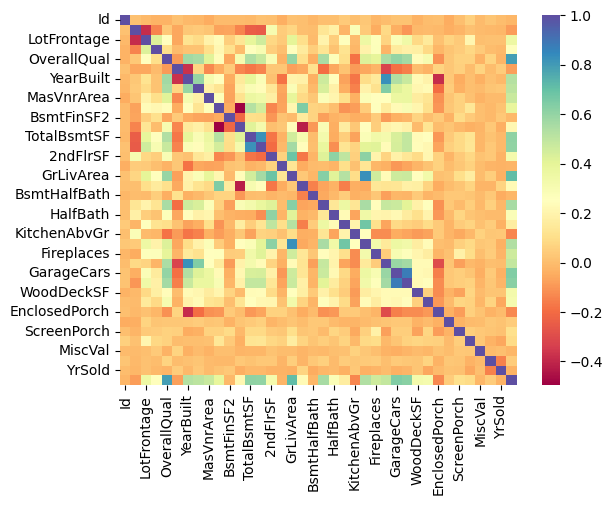

In [3]:
sns.heatmap(df_train_set.corr(numeric_only=True),cmap=sns.color_palette("Spectral", as_cmap=True))

Multicollinearity: 
- When two or more independent variables are highly correlated, it can lead to multicollinearity. Multicollinearity makes it difficult to assess the individual contribution of each variable to the dependent variable. This can cause issues with the stability and interpretability of the model.

Redundancy:
-  If two variables are highly correlated, they might be providing similar information to the model. In such cases, keeping both variables might not offer significant additional insights.

In [4]:

print("Number of missing values in training set :",df_train_set.isnull().sum().sum())
print("Number of missing values in test set :",df_test_set.isnull().sum().sum())

Number of missing values in training set : 7829
Number of missing values in test set : 7878


In [5]:
def pad_missing_values(df):
    for column in df.select_dtypes(exclude='number').columns:
        df[column] = df[column].fillna('None')
    for column in df.select_dtypes(include='number').columns:
        df[column] = df[column].fillna(0)
    return df
    
def features_engineering(df):
    mapping = {'NA':0,'Po':0.5,'Fa':0.75,'TA':1,'Gd':1.25,'Ex':1.5}
    df = df.replace(mapping)
    df['YrRemod2Sell'] = df['YrSold'] - df['YearRemodAdd'] 
    #df = df.drop(columns=['YrSold','YearRemodAdd']) #drop year sold and remodel but keep built year
    df['InHouseArea'] = df['1stFlrSF'] + df['2ndFlrSF'] 
    #df = df.drop(columns=['1stFlrSF', '2ndFlrSF'])
    df['PoolArea'] = df['PoolArea']
    #df = df.drop(columns=['PoolQC'])
    df['TotalOutsideAtea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    #df = df.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])
    # Create GarageCapacity
    df['GarageCap'] = (df['GarageArea']/df['GarageCars'])
    #df = df.drop(['GarageQual','GarageCond'])
    df['TotalBathroom'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']
    return df
    

In [6]:

def onehotencoding(df):
    df = features_engineering(df)
    df = pad_missing_values(df)
    df_encoded = pd.get_dummies(df, dtype=float) # one hot encoded using dummies default is Booleans
    id = df_encoded['Id']
    df_encoded.drop(columns=['SalePrice'], inplace= True)
    return df_encoded,id

    



In [7]:
df_X = pd.concat([df_train_set, df_test_set])
index = df_train_set.shape[0]
y = df_X['SalePrice']
df_encode,id = onehotencoding(df_X)
print("Number of missing values after preprocessing :",df_train_set.isnull().sum().sum())
X_train = df_encode.loc[df_encode['Id'] <= index]
X_test = df_encode.loc[df_encode['Id'] > index]
X_train =  X_train.drop(columns=['Id'])
X_test = X_test.drop(columns=['Id'])








Number of missing values after preprocessing : 7829


In [8]:
y = y.dropna()
y = np.log1p(y)

In [12]:

import keras
from keras import regularizers,layers
from keras.layers import Input,Dense,Dropout
import tensorflow as tf

In [13]:
model = keras.Sequential([
    keras.layers.Normalization(input_shape=[274,], axis=None),
    layers.BatchNormalization(),
    keras.layers.Dense(128, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    keras.layers.Dense(64, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    keras.layers.Dense(32, activation='leaky_relu'),
    layers.BatchNormalization(),
    keras.layers.Dense(1)
]
)

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 274)               3         
 on)                                                             
                                                                 
 batch_normalization (Batch  (None, 274)               1096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               35200     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [37]:

history = model.fit(
    X_train,
    y,
    epochs=500,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [55]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,0.034888,0.036606,495
496,0.030003,0.029038,496
497,0.026044,0.024365,497
498,0.023538,0.022351,498
499,0.037590,0.026872,499


In [39]:
y_predict = model.predict(X_test)
y_predict

46/46 [==============================] - 0s 936us/step


array([[11.767416 ],
       [12.0982895],
       [12.189875 ],
       ...,
       [12.0599   ],
       [11.720901 ],
       [12.2731085]], dtype=float32)

In [66]:
y_col = np.expm1(y_predict)
df_y = pd.DataFrame(y_col,columns=['Predicted price by Neural Network'])
df_y


,Predicted price by Neural Network
0,128979.437500
1,179563.453125
2,196785.500000
3,200510.468750
4,198384.718750
...,...
1454,82683.648438
1455,64529.914062
1456,172800.750000
1457,123117.250000
